<a href="https://colab.research.google.com/github/shlomihod/does-author-order-matter/blob/main/data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Does Author Order Matter?

- [ ] Better data management (sqlite?)
- [ ] `author_d`, h-index, onset, window, %first
- [ ] which disciplines are ordered
- [ ] plots


In [ ]:
if True:
    !pip install scholarmetrics
    !wget https://originalstatic.aminer.cn/misc/dblp.v12.7z
    !7z x dblp.v12.7z
    !npm install -g json2csv
    !json2csv -i dblp.v12.json -o dblp.v12.csv

  Using cached https://files.pythonhosted.org/packages/fb/48/69046506f6ac61c1eaa9a0d42d22d54673b69e176d30ca98e3f61513e980/pbr-5.5.1-py2.py3-none-any.whl
  Created wheel for scholarmetrics: filename=scholarmetrics-0.2.1-py2.py3-none-any.whl size=6021 sha256=c7eb19a928e6598fa47b91a4ba465561e6b9702462874640790dae59358b8c09
  Stored in directory: /root/.cache/pip/wheels/a8/c7/b1/f9a40af6bf012ed8d255a12092f5508727213ccac2b013f5c7
Successfully built scholarmetrics
--2020-12-02 00:57:29--  https://originalstatic.aminer.cn/misc/dblp.v12.7z
Resolving originalstatic.aminer.cn (originalstatic.aminer.cn)... 40.73.3.16
Connecting to originalstatic.aminer.cn (originalstatic.aminer.cn)|40.73.3.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2727161612 (2.5G) [application/x-7z-compressed]
Saving to: ‘dblp.v12.7z’

dblp.v12.7z         100%[===================>]   2.54G  8.49MB/s    in 5m 11s  

2020-12-02 01:02:43 (8.36 MB/s) - ‘dblp.v12.7z’ saved [2727161612/2727161612]




In [ ]:
from math import isnan
from collections import defaultdict, Counter

import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns

from scholarmetrics import hindex

In [ ]:
import dask.dataframe as dd

In [ ]:
paper_df  = pd.read_csv('./dblp.v12.csv',
                 usecols=['id', 'authors', 'n_citation', 'year'])

assert paper_df ['authors'].isna().sum() < 20
paper_df = paper_df .dropna(subset=['authors'])

In [ ]:
paper_df.info()

In [ ]:
# paper_indegree = Counter()

# count indegree citation
# for _, paper in df.iterrows():
#     if isinstance(paper['references'], str):
#         cited_papers = eval(paper['references'])
#         for cited_paper in eval(paper['references']):
#             paper_indegree[cited_paper] += 1


In [ ]:
author_d = defaultdict(dict)

THIS_YEAR = 2020

# build author dictionary
for _, paper in paper_df .iterrows():
    for author in eval(paper['authors']):
        id_ = author['id']
        author_d[id_]['name'] = author['name']
        author_d[id_].setdefault('papers', []).append(paper['id'])
        author_d[id_].setdefault('years', []).append(paper['year'])
        author_d[id_].setdefault('n_citation', []).append(paper['n_citation'])

# add indegree citation for each author's paper
for id_ in author_d:
    # author_d[id_]['indegrees'] = [paper_indegree[paper_id]
    #                               for paper_id in author_d[id_]['papers']]
    author_d[id_]['citations'] = sum(author_d[id_]['n_citation'])
    author_d[id_]['hindex'] = hindex(author_d[id_]['n_citation'])

    author_d[id_]['years_first'] = min(author_d[id_]['years'])
    author_d[id_]['years_last'] = max(author_d[id_]['years'])

    author_d[id_]['years_onset'] = THIS_YEAR - author_d[id_]['years_first']
    author_d[id_]['years_active'] = (author_d[id_]['years_last']
                                     - author_d[id_]['years_first'])

author_df = pd.DataFrame.from_dict(author_d,
                                   orient='index',
                                   columns=['name', 'hindex', 'citations',
                                            'years_first', 'years_last',
                                            'years_onset', 'years_active'])

author_df['last_name'] = author_df['name'].apply(lambda name: name.split()[-1])

In [ ]:
author_df = pd.read_feather('authors.feather')

In [ ]:
author_df.head()

,index,name,hindex,citations,years_first,years_last,years_onset,years_active
0,2312688602,Makoto Satoh,1,2,2013,2014,7,1
1,2482909946,Ryo Muramatsu,1,1,2013,2013,7,0
2,2128134587,Mizue Kayama,5,129,1998,2019,22,21
3,2101782692,Kazunori Itoh,4,45,1994,2014,26,20
4,2114054191,Masami Hashimoto,3,25,1994,2016,26,22


In [ ]:
len(author_df)

4398138

In [ ]:
recent_author_df = author_df[author_df['years_first'] >= 1960]

In [ ]:
recent_author_df[recent_author_df['hindex'] > 100]

,index,name,hindex,citations,years_first,years_last,years_onset,years_active
1840,2435751034,Michael I. Jordan,109,87762,1989,2019,31,30
2762,2125104194,Philip S. Yu,109,57431,1981,2020,39,39
7917,2469405535,Andrew Zisserman,126,92052,1986,2020,34,34
9010,2220829341,Christos H. Papadimitriou,101,41488,1976,2019,44,43
16799,2141382980,Francisco Herrera,111,49473,1994,2020,26,26
18479,2149631809,Thomas Huang,108,64727,1965,2019,55,54
26145,2198983026,Christos Faloutsos,103,52488,1982,2020,38,38
27089,2140539176,Takeo Kanade,107,59101,1973,2019,47,46
30354,2075956027,Sebastian Thrun,108,53820,1988,2017,32,29
34643,237419955,Héctor García-Molina,105,44439,1978,2019,42,41


In [ ]:
recent_author_df[recent_author_df['last_name'] == 'Filan']

,index,name,hindex,citations,years_first,years_last,years_onset,years_active,last_name
2780838,2341219775,Daniel Filan,1,13,2016,2018,4,2,Filan
4354344,2674518228,Daniel Filan,1,1,2017,2017,3,0,Filan


In [ ]:
from scipy.stats import spearmanr, kendalltau

In [ ]:
spearmanr(recent_author_df['hindex'], recent_author_df['name'])

SpearmanrResult(correlation=-0.0379018501811604, pvalue=0.0)

In [ ]:
spearmanr(recent_author_df['hindex'], recent_author_df['last_name'])

SpearmanrResult(correlation=-0.03228711292117577, pvalue=0.0)

In [ ]:
spearmanr(recent_author_df['hindex'], recent_author_df['years_active'])

SpearmanrResult(correlation=0.6477591473583352, pvalue=0.0)

In [ ]:
spearmanr(recent_author_df['hindex'], recent_author_df['years_onset'])

SpearmanrResult(correlation=0.3083028983386319, pvalue=0.0)

In [ ]:
hindex_rank = recent_author_df['hindex'].rank()
name_rank = recent_author_df['name'].rank()
years_active_rank = recent_author_df['years_active'].rank()

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


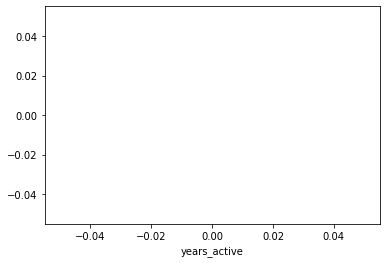

In [ ]:
sns.lineplot(recent_author_df['years_active'])

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


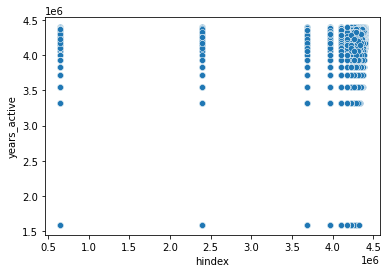

In [ ]:
sns.scatterplot(hindex_rank, years_active_rank)